## Packages

In [2]:
from datetime import datetime, timedelta
import pandas as pd
import os
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from sunpy.timeseries.sources.goes import XRSTimeSeries
import astropy.units as u
from sunkit_instruments.goes_xrs import calculate_temperature_em
import matplotlib.pyplot as plt
import numpy as np
from sunpy.data import manager
import netCDF4 as nc
import os
import pandas as pd
from datetime import datetime, timedelta
import copy
from matplotlib import colormaps
list(colormaps)
#from colorspacious import cspace_converter
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterMathtext
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob

## Funciones gráficas

In [3]:
# Plot with ticks every minute
def plot_fai_and_flare_lines(df_combined, df_fai_selected, df_fai_all, df_flare_data, 
                              flare_start_time, flare_end_time, graphics_dir,
                              ymin=1e-9, ymax=1e-4):
    """
    Plots XRS A and B on a logarithmic scale with vertical lines for FAI events and flare times.
    df_fai_all: all candidate FAI events
    df_fai_selected: FAI events selected by a method
    """
    import matplotlib.dates as mdates
    import os
    
    # Ensure time types
    flare_start_time = pd.to_datetime(flare_start_time)
    flare_end_time = pd.to_datetime(flare_end_time)
    
    print(f"Buscando datos entre: {flare_start_time} y {flare_end_time}")

    # Convert date columns to datetime if they aren't already
    df_combined['date'] = pd.to_datetime(df_combined['date'])
    df_fai_selected['date'] = pd.to_datetime(df_fai_selected['date'])
    df_fai_all['date'] = pd.to_datetime(df_fai_all['date'])
    df_flare_data['StartTime'] = pd.to_datetime(df_flare_data['StartTime'])
    df_flare_data['PeakTime'] = pd.to_datetime(df_flare_data['PeakTime'])
    df_flare_data['EndTime'] = pd.to_datetime(df_flare_data['EndTime'])

    # DEBUG: Verificar rangos de fechas en los dataframes
    print(f"Rango df_combined: {df_combined['date'].min()} a {df_combined['date'].max()}")
    print(f"Rango df_fai_selected: {df_fai_selected['date'].min()} a {df_fai_selected['date'].max()}")
    print(f"Rango df_flare_data PeakTime: {df_flare_data['PeakTime'].min()} a {df_flare_data['PeakTime'].max()}")

    # Filter data based on date column - método más robusto
    mask_combined = (df_combined['date'] >= flare_start_time) & (df_combined['date'] <= flare_end_time)
    df_plot = df_combined.loc[mask_combined].copy()
    
    mask_fai = (df_fai_selected['date'] >= flare_start_time) & (df_fai_selected['date'] <= flare_end_time)
    df_fai_interval = df_fai_selected.loc[mask_fai].copy()

    mask_fai_all = (df_fai_all['date'] >= flare_start_time) & (df_fai_all['date'] <= flare_end_time)
    df_fai_all_interval = df_fai_all.loc[mask_fai_all].copy()


    # DEBUG: Verificar cuántos datos encontramos
    print(f"Datos en df_plot: {len(df_plot)}")
    print(f"Datos en df_fai_interval: {len(df_fai_interval)}")

    # Si no hay datos en el rango, mostrar advertencia
    if len(df_plot) == 0:
        print(f"¡ADVERTENCIA! No hay datos en df_combined para el rango {flare_start_time} a {flare_end_time}")
        return

    plt.rcParams.update({
        "axes.titlesize": 16, "axes.labelsize": 16, 
        "xtick.labelsize": 15, "ytick.labelsize": 15, 
        "legend.fontsize": 13
    })

    # Create figure
    fig, ax = plt.subplots(figsize=(13, 5))

    # Plot XRS A and B usando el índice numérico para evitar problemas con fechas
    x_vals = range(len(df_plot))  # Usar índice numérico para el plotting
    ax.plot(x_vals, df_plot['xrsa'], label='XRS A', color='blue', linewidth=1)
    ax.plot(x_vals, df_plot['xrsb'], label='XRS B', color='red', linewidth=1)

    # Log scale and Y-axis limits
    ax.set_yscale('log')
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('X-ray Flux [W/m²]')
    ax.set_xlabel(f"Time [UTC] – {flare_start_time:%d %b %Y}")
    ax.set_title(f'XRS A and B with FAI and Flare Times\n{flare_start_time:%Y-%m-%d %H:%M} to {flare_end_time:%H:%M}')
    ax.grid(True, alpha=0.3)
    
    # -----------------------
    # Configure X axis ticks
    # -----------------------
    # Crear un array de minutos dentro del intervalo de flare
    start_time = flare_start_time
    end_time = flare_end_time

    # Generar ticks mayores cada 10 minutos
    major_times = pd.date_range(start=start_time.ceil('10min'), end=end_time, freq='10min')
    major_indices = [(np.abs(df_plot['date'] - t)).argmin() for t in major_times]
    major_labels = [t.strftime('%H:%M') for t in major_times]

    # Generar ticks menores cada 1 minuto
    minor_times = pd.date_range(start=start_time.ceil('1min'), end=end_time, freq='1min')
    minor_indices = [(np.abs(df_plot['date'] - t)).argmin() for t in minor_times]

    # Asignar ticks al eje X
    ax.set_xticks(major_indices)
    ax.set_xticklabels(major_labels)
    ax.set_xticks(minor_indices, minor=True)  # minor ticks sin etiquetas
    

    # -----------------------
    # Plot all FAI candidates (background)
    # -----------------------
    for i, fai_time in enumerate(df_fai_all_interval['date']):
        idx = (np.abs(df_plot['date'] - fai_time)).argmin()
        ax.axvline(x=idx, color='#FF69B4', linestyle='-', linewidth=1.5, alpha=0.7,
                   label='FAI Candidate' if i == 0 else "")


    # Red vertical lines: FAI events
    for fai_time in df_fai_interval['date']:
        # Encontrar la posición en el plot para este tiempo FAI
        time_diff = np.abs(df_plot['date'] - fai_time)
        if len(time_diff) > 0:
            idx = time_diff.argmin()
            ax.axvline(x=idx, color='red', linestyle='-', linewidth=1.5, alpha=0.7,
                      label='FAI Alert' if fai_time == df_fai_interval['date'].iloc[0] else "")

    # Encontrar fulguraciones en el intervalo de tiempo
    flares_in_interval = df_flare_data[
        (df_flare_data['PeakTime'] >= flare_start_time) & 
        (df_flare_data['PeakTime'] <= flare_end_time)
    ]
    
    print(f"Fulguraciones encontradas en el intervalo: {len(flares_in_interval)}")

    # Colores y estilos para los diferentes tiempos de las fulguraciones
    for idx, (_, row) in enumerate(flares_in_interval.iterrows()):
        start_time = row['StartTime']
        peak_time = row['PeakTime']
        end_time = row['EndTime']
        flare_class = row.get('Class', '')
        
        # Función para encontrar la posición en el plot
        def find_time_position(time_val):
            time_diff = np.abs(df_plot['date'] - time_val)
            if len(time_diff) > 0:
                return time_diff.argmin()
            return None
        
        # Línea verde punteada para StartTime
        if flare_start_time <= start_time <= flare_end_time:
            start_pos = find_time_position(start_time)
            if start_pos is not None:
                ax.axvline(x=start_pos, color='green', linestyle=(0, (5, 3)), linewidth=2, alpha=0.8,
                          label='Flare Start' if idx == 0 else "")
        
        # Línea azul discontinua para PeakTime
        if flare_start_time <= peak_time <= flare_end_time:
            peak_pos = find_time_position(peak_time)
            if peak_pos is not None:
                #ax.axvline(x=peak_pos, color='blue', linestyle='--', linewidth=2, alpha=0.8,
                ax.axvline(x=peak_pos, color='blue', linestyle=(0, (5, 3)), linewidth=2, alpha=0.8,
                          label='Flare Peak' if idx == 0 else "")
                
                # AÑADIR FLECHA QUE SEÑALA EL PEAK
                # Encontrar el valor de flujo en el peak time
                peak_flux = None
                peak_time_diff = np.abs(df_plot['date'] - peak_time)
                if len(peak_time_diff) > 0:
                    peak_idx = peak_time_diff.argmin()
                    # Usar el mayor flujo entre XRS A y XRS B
                    peak_flux = max(df_plot['xrsa'].iloc[peak_idx], df_plot['xrsb'].iloc[peak_idx])
                

        
        # Línea amarilla punteada para EndTime
        if flare_start_time <= end_time <= flare_end_time:
            end_pos = find_time_position(end_time)
            if end_pos is not None:
                ax.axvline(x=end_pos, color='orange', linestyle='--', linewidth=3, alpha=0.8,
                          label='Flare End' if idx == 0 else "")
        
        # Anotación con la clase de la fulguración Y FLECHA
        if flare_class and (flare_start_time <= peak_time <= flare_end_time):
            peak_pos = find_time_position(peak_time)
            if peak_pos is not None:
                ax.annotate(flare_class,
                            xy=(peak_pos, ymin * 5),  # Punto destino
                            xytext=(peak_pos + 1, ymin * 15),  # Punto origen (más a la derecha y arriba)
                            fontsize=9,
                            color='darkblue',
                            rotation=0,
                            ha='left',
                            va='center',
                            bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="darkblue", lw=1, alpha=0.8),
                            arrowprops=dict(arrowstyle='->',  # Flecha
                                          color='darkblue',
                                          lw=1,
                                          alpha=0.7,
                                          shrinkA=5,  # Espacio en el origen
                                          shrinkB=0))  # Sin espacio en el destino

    # Final layout with proper legend handling
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates
    ax.legend(by_label.values(), by_label.keys(), loc="upper right")
    

    fig.tight_layout()

    # Create graphics directory if it doesn't exist
    #graphics_dir = "graphics"
    #os.makedirs(graphics_dir, exist_ok=True)

    #en esta función se recibe el directorio como parámetro
    
    output_name = f"FAI_{flare_start_time:%Y%m%d_%H%M}_{flare_end_time:%H%M}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


#gráfica ce flux vs EM y T
def plot_xrs_vs_te_simple(days, 
                         df_full_valid, 
                         df_flares_valid, 
                         time_column="PeakTime",
                         XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                         color_by=None,
                         palette="viridis",  
                         class_to_color=None):
    """
    Versión simplificada que asume que podemos hacer merge por tiempo
    """
    
    # Convertir a datetime
    df_full_valid['date'] = pd.to_datetime(df_full_valid['date'])
    df_flares_valid[time_column] = pd.to_datetime(df_flares_valid[time_column])
    
    # Hacer merge de los dataframes
    df_merged = pd.merge(df_flares_valid, df_full_valid, 
                        left_on=time_column, 
                        right_on='date', 
                        how='inner')
    
    if len(df_merged) == 0:
        print("No hay coincidencias entre los dataframes.")
        return
    
    # Filtrar datos válidos
    valid_data = df_merged.dropna(subset=[XRS, T, EM])
    
    if len(valid_data) == 0:
        print("No hay datos válidos después de filtrar NaNs.")
        return
    
    print(f"Datos válidos para graficar: {len(valid_data)}")
    
    # Preparar datos
    xrs_vals = valid_data[XRS].values
    em_vals = valid_data[EM].values
    t_vals = valid_data[T].values
    
    # Preparar labels para colores
    if color_by == "Class":
        flare_labels = valid_data["Class"].astype(str).str[0].tolist()  # solo letra B,C,M,X
    elif color_by == "Date":
        flare_labels = valid_data[time_column].dt.date.astype(str).tolist()
    elif color_by == "observatory":
        flare_labels = valid_data["observatory"].fillna("Unknown").tolist()
    else:
        flare_labels = [""] * len(valid_data)

    # --- Colores según selección ---
    if color_by:
        labels = sorted(set(flare_labels))
        if class_to_color is None:
            cmap = plt.get_cmap(palette, len(labels))
            class_to_color = {lab: cmap(i) for i, lab in enumerate(labels)}
        colors = [class_to_color[lab] for lab in flare_labels]
    else:
        labels = []
        colors = "blue"

    # Configuración de plot
    plt.rcParams.update({
        "axes.titlesize": 17, "axes.labelsize": 15,
        "xtick.labelsize": 16, "ytick.labelsize": 16,
        "legend.fontsize": 16
    })

    fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)

    # XRS vs EM
    axes[0].scatter(em_vals, xrs_vals, c=colors, alpha=0.7, s=50)
    axes[0].set_xlabel(rf"EM$_{{49}}$ [cm$^{{-3}}$]")
    axes[0].set_ylabel(rf"{XRS} [W/m$^2$]")
    axes[0].set_title(f"X-ray flux vs Emission Measure\n{days} days ({time_column})", pad=20)
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].set_xlim(0.001, None)
    
    # XRS vs T
    axes[1].scatter(t_vals, xrs_vals, c=colors, alpha=0.7, s=50)
    axes[1].set_xlabel(f"T [MK]")
    axes[1].set_ylabel(rf"{XRS} [W/m$^2$]")
    axes[1].set_title(f"X-ray flux vs Temperature\n{days} days ({time_column})", pad=20)
    axes[1].set_xscale("linear")
    axes[1].set_yscale("log")
    axes[1].set_xlim(0, 30)

    # Leyenda
    if color_by and labels:
        handles = [plt.Line2D([], [], marker="o", color=class_to_color[lab], linestyle="", 
                             label=str(lab), markersize=12) for lab in labels]
        
        n_labels = len(labels)

        # Obtener posición de los subplots combinados (en coordenadas de la figura)
        pos0 = axes[0].get_position()
        pos1 = axes[1].get_position()
        subplot_left = pos0.x0
        subplot_right = pos1.x1
        subplot_width = subplot_right - subplot_left
        
        # Número de columnas dinámico según ancho de subplots
        items_per_row = max(1, int(subplot_width * 12))  # escala arbitraria, ajustar si se quiere
        ncol = min(n_labels, items_per_row)
        n_rows = int(np.ceil(n_labels / ncol))

        fig.legend(handles=handles, title=color_by,
                  loc="upper center", bbox_to_anchor=(0.5, -0.05),
                  ncol=min(4, len(labels)), frameon=False,
                  title_fontsize=17) #tamaño de título

    # Guardar
    output_name = f"{days}d_{XRS}_vs_{T}_{EM}_{time_column}_{color_by}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


##

## Carpeta para gráficas

In [4]:
n=185
window_minutes=30
fai_temp_range = (7, 14)
fai_em_threshold = 0.005
date_column = "date"
duration = True
FAI_duration = 3
filter_flare_coincidence = True
method = "true" # "all", "true" o "filtered"

# Obtener fecha actual en formato YYYY-MM-DD
#fecha_actual = datetime.now().strftime("%Y-%m-%d")
fecha_actual = "2025-11-04"
window_minutes=30
output_dir = f"{fecha_actual}_Analysis_for_{n}_days/GraphicsFAI(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{duration}_{FAI_duration}"

folder = f"Graphics_{method}"

# Crear subcarpeta para guardar resultados de análisis
graphics_dir = os.path.join(output_dir, folder)
# Crear subcarpeta para guardar resultados de análisis (si no existe) y mostrar mensaje
if os.path.exists(graphics_dir):
    print(f"⚠️ La carpeta de análisis ya existía: {graphics_dir}")
else:
    os.makedirs(graphics_dir , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {graphics_dir}")



⚠️ La carpeta de análisis ya existía: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_true


## llamar datos

In [5]:
# Path of cleaned data in csv
csv_path_full_valid = f"{fecha_actual}_Analysis_for_{n}_days/df_full_{n}_valid.csv"
# Path of valid flares: 
csv_path_flares = f"{fecha_actual}_Analysis_for_{n}_days/df_flares_{n}_valid.csv"
# Path of df_full
csv_path_full = f"{fecha_actual}_Analysis_for_{n}_days/df_full_goes_{n}.csv"


# Path of anticipation_time
csv_path_anticipation_time = f"{fecha_actual}_Analysis_for_{n}_days/Analysis_FAI/df_anticipation_time_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of fai_all
csv_path_fai_all = f"{fecha_actual}_Analysis_for_{n}_days/Analysis_FAI/df_fai_all_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of fai_selected
csv_path_fai_selected = f"{fecha_actual}_Analysis_for_{n}_days/Analysis_FAI/df_fai_{method}_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of df_fai_assoc
csv_path_fai_assoc = f"{fecha_actual}_Analysis_for_{n}_days/Analysis_FAI/df_fai_assoc_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"

df_full_valid = pd.read_csv(csv_path_full_valid)
df_flares_valid = pd.read_csv(csv_path_flares)
df_anticipation_time = pd.read_csv(csv_path_anticipation_time)
df_fai_all = pd.read_csv(csv_path_fai_all)
df_fai_selected = pd.read_csv(csv_path_fai_selected)
df_full = pd.read_csv(csv_path_full)
df_fai_assoc = pd.read_csv(csv_path_fai_assoc)

## Info dfs

In [6]:
df_full_valid["date"] = pd.to_datetime(df_full_valid["date"])
df_flares_valid["StartTime"] = pd.to_datetime(df_flares_valid["StartTime"])
df_flares_valid["PeakTime"]  = pd.to_datetime(df_flares_valid["PeakTime"])
df_flares_valid["EndTime"]   = pd.to_datetime(df_flares_valid["EndTime"])
df_anticipation_time["StartTime"] = pd.to_datetime(df_anticipation_time["StartTime"])
df_anticipation_time["PeakTime"]  = pd.to_datetime(df_anticipation_time["PeakTime"])
df_anticipation_time["EndTime"]   = pd.to_datetime(df_anticipation_time["EndTime"])
df_fai_selected["date"] = pd.to_datetime(df_fai_selected["date"])

In [7]:
df_full_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64604 entries, 0 to 64603
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   GOES_ID       64604 non-null  object        
 1   date          64604 non-null  datetime64[ns]
 2   observatory   64604 non-null  object        
 3   xrsa          64604 non-null  float64       
 4   xrsb          64604 non-null  float64       
 5   xrsa_corr     64604 non-null  float64       
 6   xrsb_corr     64604 non-null  float64       
 7   T_cor         64604 non-null  float64       
 8   EM_cor        64604 non-null  float64       
 9   T_phot        64604 non-null  float64       
 10  EM_phot       64604 non-null  float64       
 11  EM_cor_norm   64604 non-null  float64       
 12  EM_phot_norm  64604 non-null  float64       
dtypes: datetime64[ns](1), float64(10), object(2)
memory usage: 6.4+ MB


In [8]:
df_flares_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Flare_ID     2020 non-null   object        
 1   StartTime    2020 non-null   datetime64[ns]
 2   PeakTime     2020 non-null   datetime64[ns]
 3   EndTime      2020 non-null   datetime64[ns]
 4   Class        2020 non-null   object        
 5   ClassLetter  2020 non-null   object        
 6   ClassNumber  2020 non-null   float64       
 7   ClassGroup   2020 non-null   object        
 8   Observatory  2020 non-null   object        
 9   StartPeak    2020 non-null   float64       
 10  PeakEnd      2020 non-null   float64       
 11  StartEnd     2020 non-null   float64       
dtypes: datetime64[ns](3), float64(4), object(5)
memory usage: 189.5+ KB


In [9]:
df_anticipation_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Flare_ID                    2020 non-null   object        
 1   StartTime                   2020 non-null   datetime64[ns]
 2   PeakTime                    2020 non-null   datetime64[ns]
 3   EndTime                     2020 non-null   datetime64[ns]
 4   Class                       2020 non-null   object        
 5   ClassLetter                 2020 non-null   object        
 6   ClassNumber                 2020 non-null   float64       
 7   ClassGroup                  2020 non-null   object        
 8   Observatory                 2020 non-null   object        
 9   StartPeak                   2020 non-null   float64       
 10  PeakEnd                     2020 non-null   float64       
 11  StartEnd                    2020 non-null   float64     

In [10]:
df_fai_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20598 entries, 0 to 20597
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   GOES_ID       20598 non-null  object        
 1   date          20598 non-null  datetime64[ns]
 2   observatory   20598 non-null  object        
 3   xrsa          20598 non-null  float64       
 4   xrsb          20598 non-null  float64       
 5   xrsa_corr     20598 non-null  float64       
 6   xrsb_corr     20598 non-null  float64       
 7   T_cor         20598 non-null  float64       
 8   EM_cor        20598 non-null  float64       
 9   T_phot        20598 non-null  float64       
 10  EM_phot       20598 non-null  float64       
 11  EM_cor_norm   20598 non-null  float64       
 12  EM_phot_norm  20598 non-null  float64       
dtypes: datetime64[ns](1), float64(10), object(2)
memory usage: 2.0+ MB


In [11]:
df_fai_assoc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20598 entries, 0 to 20597
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GOES_ID           20598 non-null  object 
 1   date              20598 non-null  object 
 2   observatory       20598 non-null  object 
 3   xrsa              20598 non-null  float64
 4   xrsb              20598 non-null  float64
 5   xrsa_corr         20598 non-null  float64
 6   xrsb_corr         20598 non-null  float64
 7   T_cor             20598 non-null  float64
 8   EM_cor            20598 non-null  float64
 9   T_phot            20598 non-null  float64
 10  EM_phot           20598 non-null  float64
 11  EM_cor_norm       20598 non-null  float64
 12  EM_phot_norm      20598 non-null  float64
 13  Time_FAI          20598 non-null  object 
 14  Associated_Flare  20598 non-null  bool   
 15  Flare_ID          9882 non-null   object 
 16  F_StartTime       9882 non-null   object

## Búsqueda individual

In [12]:
pd.set_option('display.max_columns', None)
df_fai_assoc.iloc[:3]

,GOES_ID,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,Time_FAI,Associated_Flare,Flare_ID,F_StartTime,F_PeakTime,F_EndTime,F_Class,F_ClassLetter,F_ClassNumber,F_ClassGroup,F_Observatory,F_StartPeak,F_PeakEnd,F_StartEnd,Association_Type,Time_to_flare,FAI_to_start,FAI_to_peak,FAI_to_end
0,GOES_10,2000-06-06 00:17:00,GOES-16,4.194724e-08,0.000001,2.585677e-08,2.906549e-07,11.058271,1.937464e+47,9.953444,5.260247e+47,0.019375,0.052602,2000-06-06 00:17:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,26.0,11.0,26.0,38.0
1,GOES_11,2000-06-06 00:23:00,GOES-16,4.063336e-08,0.000001,4.950806e-09,1.062962e-07,8.298321,1.054738e+47,7.279352,3.402429e+47,0.010547,0.034024,2000-06-06 00:23:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,20.0,5.0,20.0,32.0
2,GOES_12,2000-06-06 00:24:00,GOES-16,4.321096e-08,0.000001,8.710359e-09,1.461166e-07,9.254645,1.224493e+47,8.167912,3.721751e+47,0.012245,0.037218,2000-06-06 00:24:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,19.0,4.0,19.0,31.0


In [13]:
df_anticipation_time.sort_values(by="FAIalerts_W", ascending=False)[:2]

,Flare_ID,StartTime,PeakTime,EndTime,Class,ClassLetter,ClassNumber,ClassGroup,Observatory,StartPeak,PeakEnd,StartEnd,FAIalerts_W,FAIalerts_WStart,FAIalerts_WPeak,FAIalerts_StartPeak,FAIalerts_PeakEnd,FAIalerts_startEnd,AnticipationStart,AnticipationPeak,Peak_to_lastFAI,Time_since_prev_flare_end,Time_since_prev_flare_peak,RelAnticipation_Peak,RelAnticipation_Start
1025,Flare_20141026_1025,2014-10-26 17:08:00,2014-10-26 17:17:00,2014-10-26 17:30:00,M1.0,M,1.0,M1-4.9,GOES,9.0,13.0,22.0,30,19,28,9,2,11,19.0,28.0,-1.0,55.0,60.0,3.111111,2.111111
1369,Flare_20230805_1369,2023-08-05 06:16:00,2023-08-05 07:18:00,2023-08-05 09:06:00,M1.6,M,1.6,M1-4.9,GOES,62.0,108.0,170.0,30,0,28,28,2,30,NaN,30.0,-55.0,102.0,109.0,0.483871,NaN


In [14]:
flare_id = "Flare_20000606_0"
df_fai_assoc[df_fai_assoc["Flare_ID"] == flare_id]


,GOES_ID,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,Time_FAI,Associated_Flare,Flare_ID,F_StartTime,F_PeakTime,F_EndTime,F_Class,F_ClassLetter,F_ClassNumber,F_ClassGroup,F_Observatory,F_StartPeak,F_PeakEnd,F_StartEnd,Association_Type,Time_to_flare,FAI_to_start,FAI_to_peak,FAI_to_end
0,GOES_10,2000-06-06 00:17:00,GOES-16,4.194724e-08,0.000001,2.585677e-08,2.906549e-07,11.058271,1.937464e+47,9.953444,5.260247e+47,0.019375,0.052602,2000-06-06 00:17:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,26.0,11.0,26.0,38.0
1,GOES_11,2000-06-06 00:23:00,GOES-16,4.063336e-08,0.000001,4.950806e-09,1.062962e-07,8.298321,1.054738e+47,7.279352,3.402429e+47,0.010547,0.034024,2000-06-06 00:23:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,20.0,5.0,20.0,32.0
2,GOES_12,2000-06-06 00:24:00,GOES-16,4.321096e-08,0.000001,8.710359e-09,1.461166e-07,9.254645,1.224493e+47,8.167912,3.721751e+47,0.012245,0.037218,2000-06-06 00:24:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,19.0,4.0,19.0,31.0
3,GOES_13,2000-06-06 00:25:00,GOES-16,4.753495e-08,0.000001,8.936986e-09,1.561961e-07,9.086959,1.344306e+47,8.010274,4.128245e+47,0.013443,0.041282,2000-06-06 00:25:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,18.0,3.0,18.0,30.0
4,GOES_14,2000-06-06 00:26:00,GOES-16,5.612609e-08,0.000001,1.455322e-08,2.010820e-07,10.094641,1.496619e+47,8.974755,4.320921e+47,0.014966,0.043209,2000-06-06 00:26:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,17.0,2.0,17.0,29.0
5,GOES_15,2000-06-06 00:27:00,GOES-16,6.899128e-08,0.000002,2.759433e-08,3.362277e-07,10.674135,2.335360e+47,9.555280,6.500427e+47,0.023354,0.065004,2000-06-06 00:27:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,16.0,1.0,16.0,28.0
6,GOES_16,2000-06-06 00:28:00,GOES-16,8.993616e-08,0.000002,4.930280e-08,4.731387e-07,11.832619,2.934333e+47,10.791647,7.563609e+47,0.029343,0.075636,2000-06-06 00:28:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,15.0,0.0,15.0,27.0
7,GOES_17,2000-06-06 00:29:00,GOES-16,1.181016e-07,0.000002,7.489061e-08,6.372383e-07,12.440628,3.766149e+47,11.479448,9.318636e+47,0.037661,0.093186,2000-06-06 00:29:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,14.0,-1.0,14.0,26.0
8,GOES_18,2000-06-06 00:30:00,GOES-16,1.437521e-07,0.000002,9.621716e-08,7.893004e-07,12.629187,4.602123e+47,11.696755,1.124627e+48,0.046021,0.112463,2000-06-06 00:30:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,13.0,-2.0,13.0,25.0
9,GOES_19,2000-06-06 00:31:00,GOES-16,1.849581e-07,0.000002,1.288320e-07,9.993400e-07,12.921346,5.713299e+47,12.036984,1.369641e+48,0.057133,0.136964,2000-06-06 00:31:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,12.0,-3.0,12.0,24.0


In [15]:
flare_id = "M5.3_2021-10-28T15:35:00"
df_fai_assoc[df_fai_assoc["Flare_ID"] == flare_id]


,GOES_ID,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,Time_FAI,Associated_Flare,Flare_ID,F_StartTime,F_PeakTime,F_EndTime,F_Class,F_ClassLetter,F_ClassNumber,F_ClassGroup,F_Observatory,F_StartPeak,F_PeakEnd,F_StartEnd,Association_Type,Time_to_flare,FAI_to_start,FAI_to_peak,FAI_to_end


# Gráficas

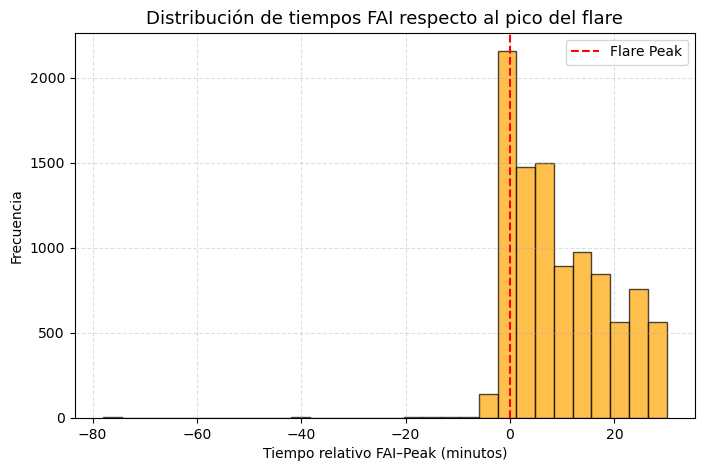

In [16]:
# Eliminar los valores NaN
data = df_fai_assoc["FAI_to_peak"].dropna()

plt.figure(figsize=(8, 5))
plt.hist(data, bins=30, color="orange", edgecolor="black", alpha=0.7)

# Línea vertical en 0 → indica el momento del pico del flare
plt.axvline(0, color="red", linestyle="--", label="Flare Peak")

plt.title("Distribución de tiempos FAI respecto al pico del flare", fontsize=13)
plt.xlabel("Tiempo relativo FAI–Peak (minutos)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


## gráficas relativas

In [17]:
# Filtramos solo FAIs asociados a flares (opcional si quieres eliminar falsos positivos)
df_associated = df_fai_assoc[df_fai_assoc["Associated_Flare"] == True].copy()

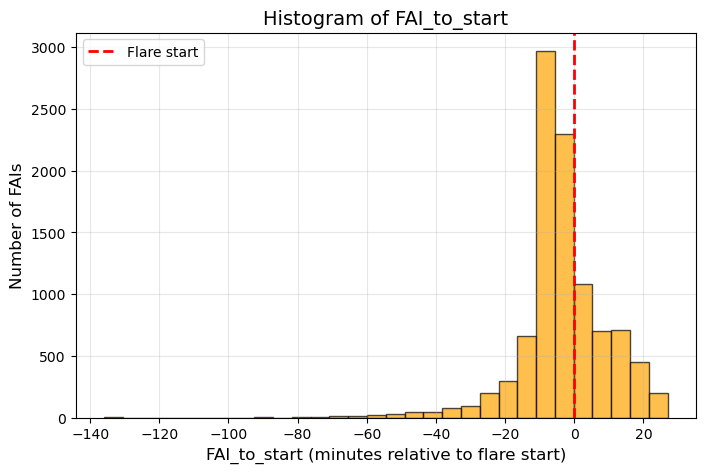

In [18]:
# Histograma absoluto de Delta T respecto al start

plt.figure(figsize=(8,5))  # tamaño más grande
plt.hist(df_associated['FAI_to_start'], bins=30, color='orange', edgecolor='black', alpha=0.7)

# Líneas de referencia
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Flare start')

# Etiquetas y título
plt.xlabel('FAI_to_start (minutes relative to flare start)', fontsize=12)
plt.ylabel('Number of FAIs', fontsize=12)
plt.title('Histogram of FAI_to_start', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)  # grid sutil

plt.show()


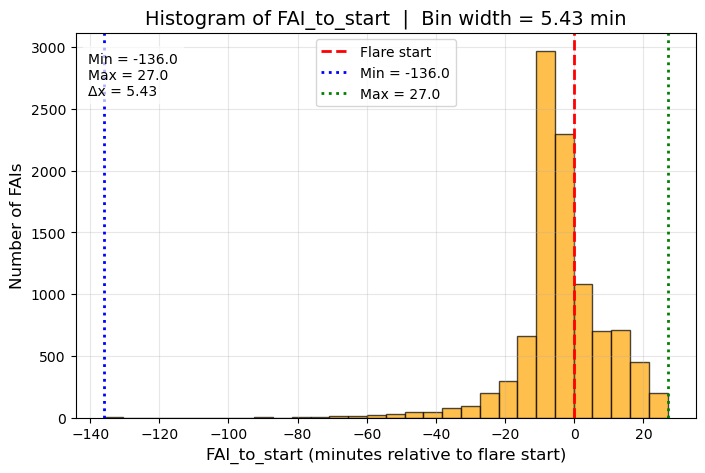

In [19]:
# Datos
x = df_associated['FAI_to_start'].dropna()

# Cálculo de histograma
counts, bin_edges = np.histogram(x, bins=30)
bin_width = bin_edges[1] - bin_edges[0]
min_val, max_val = x.min(), x.max()

# Figura
plt.figure(figsize=(8,5))
plt.hist(x, bins=30, color='orange', edgecolor='black', alpha=0.7)

# Líneas de referencia
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Flare start')
plt.axvline(min_val, color='blue', linestyle=':', linewidth=2, label=f'Min = {min_val:.1f}')
plt.axvline(max_val, color='green', linestyle=':', linewidth=2, label=f'Max = {max_val:.1f}')

# Etiquetas y título con info de bin width
plt.xlabel('FAI_to_start (minutes relative to flare start)', fontsize=12)
plt.ylabel('Number of FAIs', fontsize=12)
plt.title(f'Histogram of FAI_to_start  |  Bin width = {bin_width:.2f} min', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

# Texto adicional dentro del gráfico (opcional)
plt.text(0.02, 0.95, 
         f'Min = {min_val:.1f}\nMax = {max_val:.1f}\nΔx = {bin_width:.2f}', 
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.show()


## gráfica con bins cada 5 min

In [36]:
min_val = x.min()
max_val = x.max()
min_val_ajustado = 5 * np.floor(min_val / 5)
max_val_ajustado = 5 * np.ceil(max_val / 5)

print(f'min_val={min_val}, max_val={max_val} , min_val_ajustado={min_val_ajustado}, max_val_ajustado={max_val_ajustado}') 


min_val=-136.0, max_val=27.0 , min_val_ajustado=-140.0, max_val_ajustado=30.0


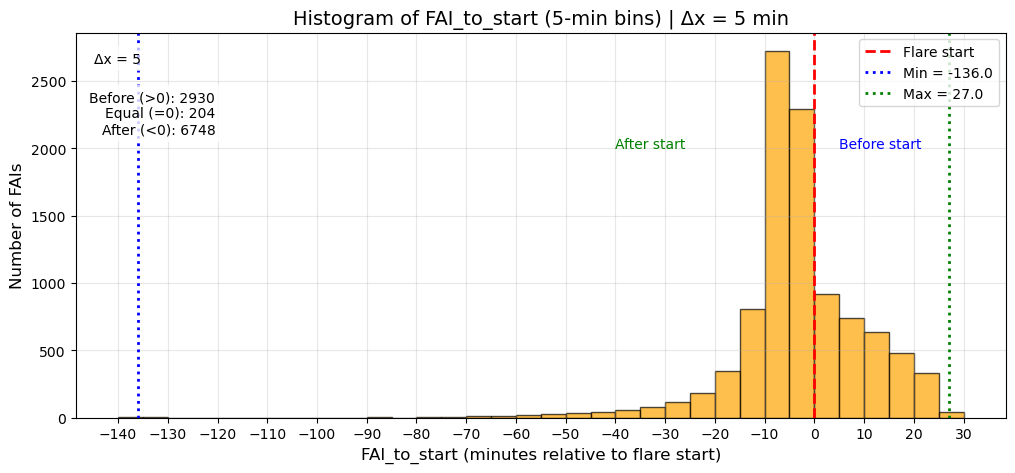

In [55]:
# Datos
x = df_associated['FAI_to_start'].dropna()

# Definir bins de 5 minutos, centrando uno en 0
min_val = x.min()
max_val = x.max()
min_val_ajustado = 5 * np.floor(min_val / 5)
max_val_ajustado = 5 * np.ceil(max_val / 5)
bin_edges = np.arange(min_val_ajustado, max_val_ajustado + 5, 5)

# Calcular histograma
counts, edges = np.histogram(x, bins=bin_edges)
bin_width = edges[1] - edges[0]

# Gráfica
plt.figure(figsize=(12,5))
plt.hist(x, bins=bin_edges, color='orange', edgecolor='black', alpha=0.7)

# Líneas de referencia
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Flare start')
plt.axvline(min_val, color='blue', linestyle=':', linewidth=2, label=f'Min = {min_val:.1f}')
plt.axvline(max_val, color='green', linestyle=':', linewidth=2, label=f'Max = {max_val:.1f}')

# Etiquetas
plt.xlabel('FAI_to_start (minutes relative to flare start)', fontsize=12)
plt.ylabel('Number of FAIs', fontsize=12)
plt.title(f'Histogram of FAI_to_start (5-min bins) | Δx = {bin_width:.0f} min', fontsize=14)
plt.legend(loc='upper right') #ubicar la leyenda arriba a la derecha
plt.grid(alpha=0.3)
plt.xticks(np.arange(min_val_ajustado, max_val_ajustado + 10, 10)) # número de Ticks en el eje x

# Texto informativo
plt.text(0.02, 0.95, 
         f'Δx = {bin_width:.0f}',
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

n_before = (x > 0).sum()   # FAI antes del start
n_equal  = (x == 0).sum()  # FAI en el start
n_after  = (x < 0).sum()   # FAI después del start

plt.text(0.15, 0.85,
         f'Before (>0): {n_before}\nEqual (=0): {n_equal}\nAfter (<0): {n_after}',
         transform=plt.gca().transAxes,
         ha='right', va='top',
         fontsize=10,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(5, plt.ylim()[1]*0.7, 'Before start', color='blue')   # valores > 0 son antes del peak
plt.text(-40, plt.ylim()[1]*0.7, 'After start', color='green')  # valores < 0 son después del peak

plt.show()


In [20]:
# Δt relativo respecto al start
df_associated['Delta_t_start_rel'] = df_associated['FAI_to_start'] / df_associated['F_StartPeak']

# Δt relativo respecto al peak
df_associated['Delta_t_peak_rel'] = df_associated['FAI_to_peak'] / df_associated['F_StartPeak']


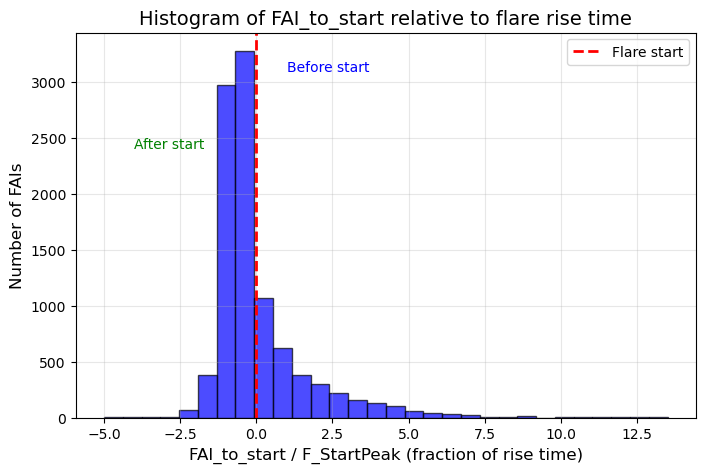

In [21]:
# Histograma relativo de Delta T / rise time (F_StartPeak)
df_associated['FAI_to_start_rel'] = df_associated['FAI_to_start'] / df_associated['F_StartPeak']

plt.figure(figsize=(8,5))
plt.hist(df_associated['FAI_to_start_rel'], bins=30, color='blue', edgecolor='black', alpha=0.7)

# Líneas de referencia
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Flare start')

plt.text(1, plt.ylim()[1]*0.9, 'Before start', color='blue')   # valores > 0 son antes del peak
plt.text(-4, plt.ylim()[1]*0.7, 'After start', color='green')  # valores < 0 son después del peak

# Etiquetas y título
plt.xlabel('FAI_to_start / F_StartPeak (fraction of rise time)', fontsize=12)
plt.ylabel('Number of FAIs', fontsize=12)
plt.title('Histogram of FAI_to_start relative to flare rise time', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)


plt.show()


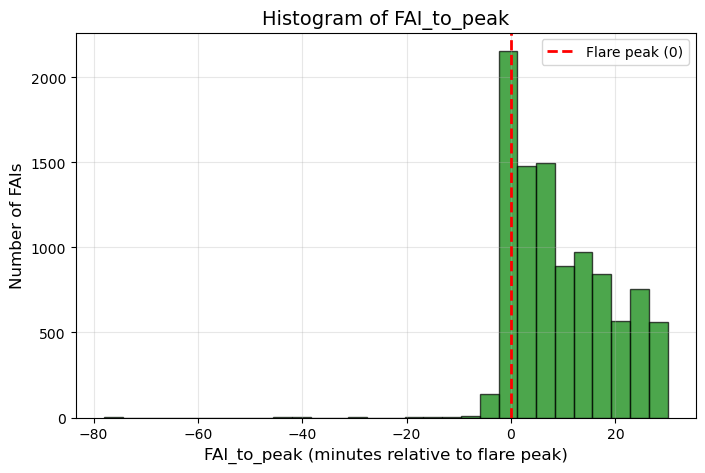

In [22]:
# Histograma absoluto de Delta T respecto al peak
plt.figure(figsize=(8,5))
plt.hist(df_associated['FAI_to_peak'], bins=30, color='green', edgecolor='black', alpha=0.7)

# Línea de referencia en 0 (flare peak)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Flare peak (0)')

# Etiquetas y título
plt.xlabel('FAI_to_peak (minutes relative to flare peak)', fontsize=12)
plt.ylabel('Number of FAIs', fontsize=12)
plt.title('Histogram of FAI_to_peak', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.show()

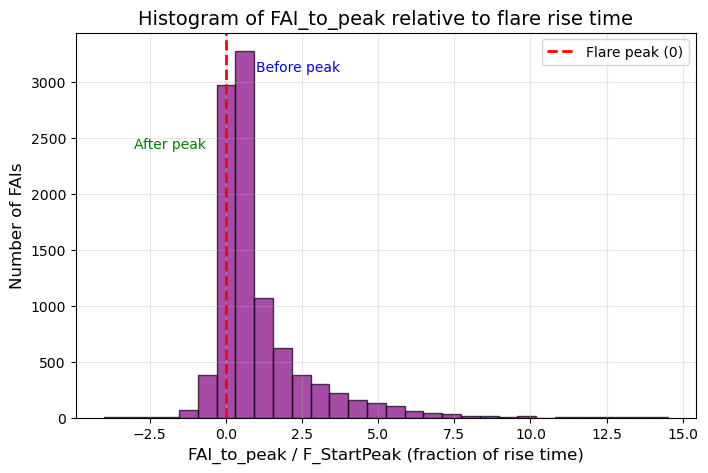

In [23]:
# Histograma relativo de Delta T / rise time respecto al peak
df_associated['FAI_to_peak_rel'] = df_associated['FAI_to_peak'] / df_associated['F_StartPeak']

plt.figure(figsize=(8,5))
plt.hist(df_associated['FAI_to_peak_rel'], bins=30, color='purple', edgecolor='black', alpha=0.7)

# Línea de referencia en 0 (flare peak)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Flare peak (0)')  # referencia en el peak

plt.text(1, plt.ylim()[1]*0.9, 'Before peak', color='blue')   # valores > 0 son antes del peak
plt.text(-3, plt.ylim()[1]*0.7, 'After peak', color='green')  # valores < 0 son después del peak

# Etiquetas y título
plt.xlabel('FAI_to_peak / F_StartPeak (fraction of rise time)', fontsize=12)
plt.ylabel('Number of FAIs', fontsize=12)
plt.title('Histogram of FAI_to_peak relative to flare rise time', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)


plt.show()



## pruebas

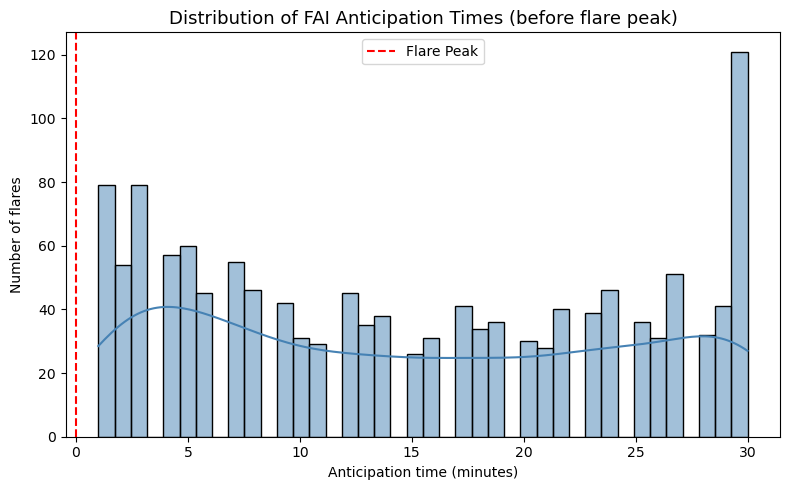

In [24]:
plt.figure(figsize=(8, 5))
sns.histplot(df_anticipation_time["AnticipationPeak"].dropna(), bins=40, kde=True, color="steelblue")
plt.axvline(0, color="red", linestyle="--", label="Flare Peak")
plt.title("Distribution of FAI Anticipation Times (before flare peak)", fontsize=13)
plt.xlabel("Anticipation time (minutes)")
plt.ylabel("Number of flares")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(graphics_dir, "hist_absolute_anticipation.png"), dpi=300)
plt.show()


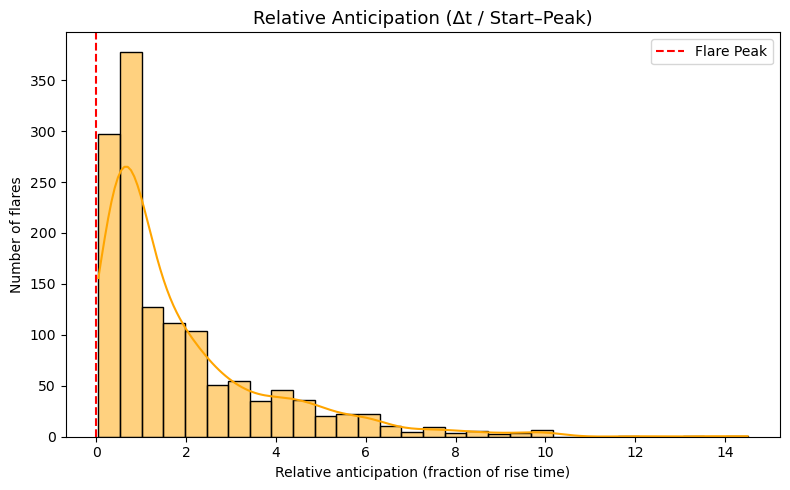

In [25]:
plt.figure(figsize=(8, 5))
sns.histplot(df_anticipation_time["RelAnticipation_Peak"].dropna(), bins=30, kde=True, color="orange")
plt.axvline(0, color="red", linestyle="--", label="Flare Peak")
plt.title("Relative Anticipation (Δt / Start–Peak)", fontsize=13)
plt.xlabel("Relative anticipation (fraction of rise time)")
plt.ylabel("Number of flares")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(graphics_dir, "hist_relative_anticipation.png"), dpi=300)
plt.show()


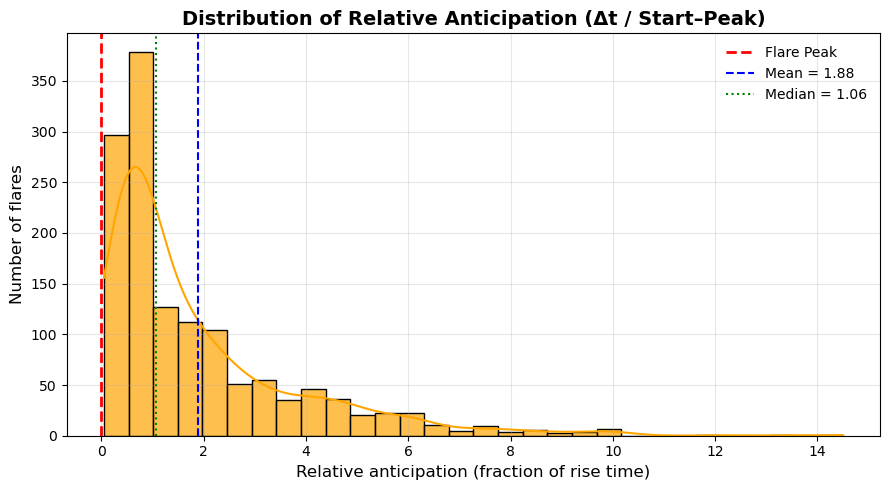

In [26]:
plt.figure(figsize=(9, 5))
sns.histplot(
    df_anticipation_time["RelAnticipation_Peak"].dropna(),
    bins=30,
    kde=True,
    color="#FFA500",  # naranja más suave
    edgecolor="black",
    alpha=0.7
)

# Línea de referencia en 0 (pico)
plt.axvline(0, color="red", linestyle="--", linewidth=2, label="Flare Peak")

# Líneas de estadísticos útiles
mean_val = df_anticipation_time["RelAnticipation_Peak"].mean()
median_val = df_anticipation_time["RelAnticipation_Peak"].median()
plt.axvline(mean_val, color="blue", linestyle="--", linewidth=1.5, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, color="green", linestyle=":", linewidth=1.5, label=f"Median = {median_val:.2f}")

# Títulos y ejes
plt.title("Distribution of Relative Anticipation (Δt / Start–Peak)", fontsize=14, weight="bold")
plt.xlabel("Relative anticipation (fraction of rise time)", fontsize=12)
plt.ylabel("Number of flares", fontsize=12)
plt.legend(frameon=False)
plt.grid(alpha=0.3)

# Márgenes y guardado
plt.tight_layout()
plt.savefig(os.path.join(graphics_dir, "hist_relative_anticipation_v2.png"), dpi=300)
plt.show()


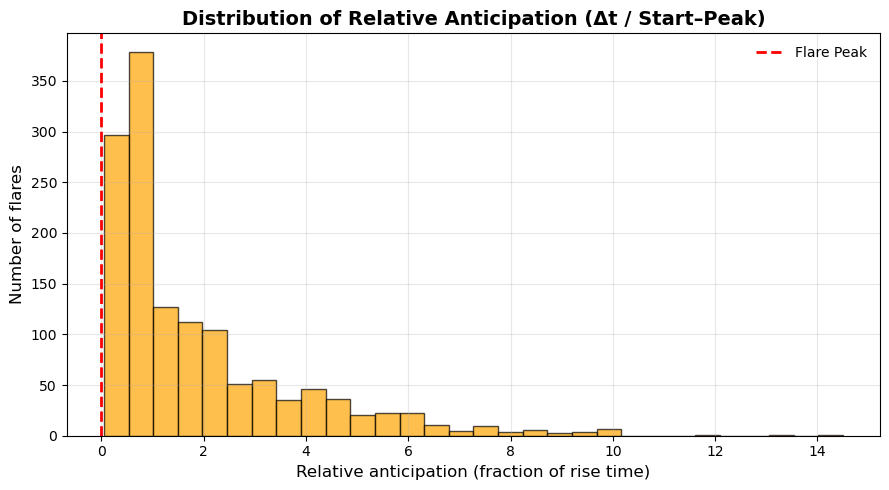

In [27]:
import matplotlib.pyplot as plt
import numpy as np

data = df_anticipation_time["RelAnticipation_Peak"].dropna()

plt.figure(figsize=(9, 5))
counts, bins, patches = plt.hist(
    data,
    bins=30,
    color="orange",
    edgecolor="black",
    alpha=0.7
)

plt.axvline(0, color="red", linestyle="--", linewidth=2, label="Flare Peak")

plt.title("Distribution of Relative Anticipation (Δt / Start–Peak)", fontsize=14, weight="bold")
plt.xlabel("Relative anticipation (fraction of rise time)", fontsize=12)
plt.ylabel("Number of flares", fontsize=12)
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


/tmp/ipykernel_4119/1990458729.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Flare class")


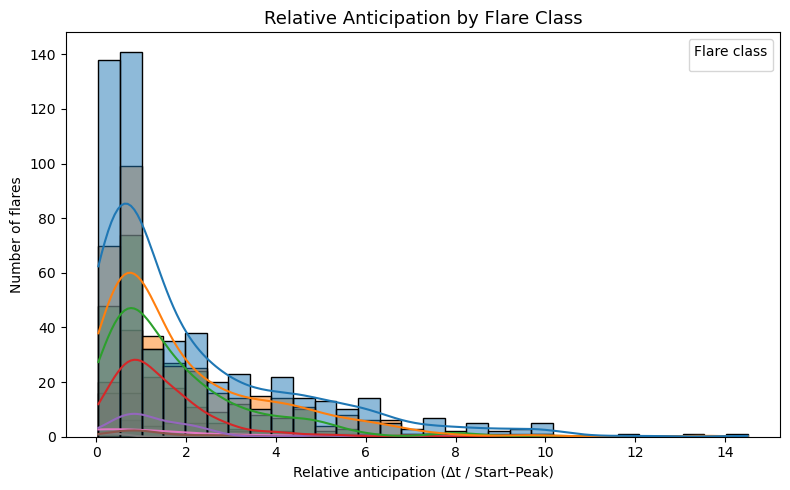

In [28]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df_anticipation_time, x="RelAnticipation_Peak", hue="ClassGroup", bins=30, kde=True)
plt.title("Relative Anticipation by Flare Class", fontsize=13)
plt.xlabel("Relative anticipation (Δt / Start–Peak)")
plt.ylabel("Number of flares")
plt.legend(title="Flare class")
plt.tight_layout()
plt.savefig(os.path.join(graphics_dir, "hist_relative_anticipation_by_class.png"), dpi=300)
plt.show()


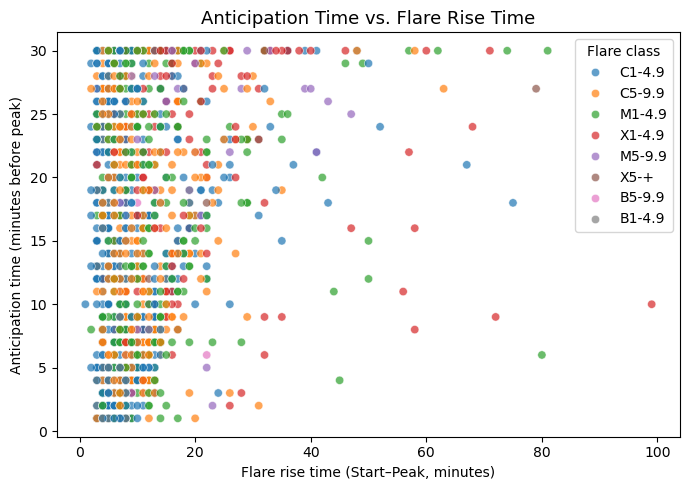

In [29]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_anticipation_time, x="StartPeak", y="AnticipationPeak", hue="ClassGroup", alpha=0.7)
plt.title("Anticipation Time vs. Flare Rise Time", fontsize=13)
plt.xlabel("Flare rise time (Start–Peak, minutes)")
plt.ylabel("Anticipation time (minutes before peak)")
plt.legend(title="Flare class")
plt.tight_layout()
plt.savefig(os.path.join(graphics_dir, "scatter_anticipation_vs_risetime.png"), dpi=300)
plt.show()


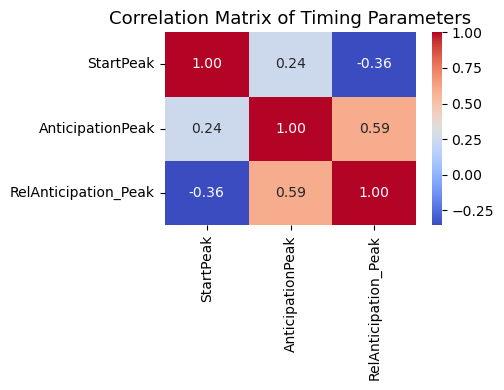

In [30]:
corr = df_anticipation_time[["StartPeak", "AnticipationPeak", "RelAnticipation_Peak"]].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Timing Parameters", fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(graphics_dir, "corr_matrix_timings.png"), dpi=300)
plt.show()


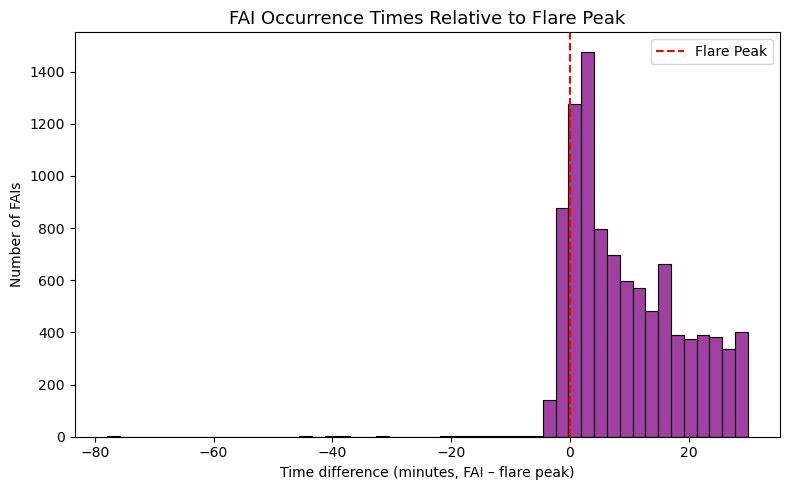

In [31]:
df_assoc = df_fai_assoc[df_fai_assoc["Associated_Flare"] == True]

plt.figure(figsize=(8, 5))
sns.histplot(df_assoc["FAI_to_peak"].dropna(), bins=50, kde=False, color="purple")
plt.axvline(0, color="red", linestyle="--", label="Flare Peak")
plt.title("FAI Occurrence Times Relative to Flare Peak", fontsize=13)
plt.xlabel("Time difference (minutes, FAI – flare peak)")
plt.ylabel("Number of FAIs")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(graphics_dir, "hist_FAI_to_peak.png"), dpi=300)
plt.show()


In [32]:
# Select only FAIs associated with a flare
df_assoc_true = df_fai_assoc[df_fai_assoc["Associated_Flare"] == True].copy()

# Sort from largest to smallest FAI_to_peak
df_assoc_sorted = df_assoc_true.sort_values(by="FAI_to_peak", ascending=False).reset_index(drop=True)

# Show first rows
df_assoc_sorted.head()


,GOES_ID,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,Time_FAI,Associated_Flare,Flare_ID,F_StartTime,F_PeakTime,F_EndTime,F_Class,F_ClassLetter,F_ClassNumber,F_ClassGroup,F_Observatory,F_StartPeak,F_PeakEnd,F_StartEnd,Association_Type,Time_to_flare,FAI_to_start,FAI_to_peak,FAI_to_end
0,GOES_46533,2024-02-09 17:30:00,GOES-16,5.103633e-07,0.000007,1.055061e-07,8.076822e-07,11.278393,3.760669e+47,10.221078,9.893705e+47,0.037607,0.098937,2024-02-09 17:30:00,True,Flare_20240209_1418,2024-02-09 17:54:00,2024-02-09 18:00:00,2024-02-09 18:07:00,M1.2,M,1.2,M1-4.9,GOES,6.0,7.0,13.0,PeakTime,30.0,24.0,30.0,37.0
1,GOES_46418,2024-02-09 07:34:00,GOES-16,4.258357e-07,0.000005,3.435122e-07,3.164886e-06,10.346988,1.637728e+48,9.274578,4.561886e+48,0.163773,0.456189,2024-02-09 07:34:00,True,Flare_20240209_1413,2024-02-09 07:52:00,2024-02-09 08:04:00,2024-02-09 08:06:00,C3.0,C,3.0,C1-4.9,GOES,12.0,2.0,14.0,PeakTime,30.0,18.0,30.0,32.0
2,GOES_47261,2024-02-21 22:01:00,GOES-16,9.396408e-08,0.000002,3.941456e-08,2.983811e-07,11.336548,1.381165e+47,10.282110,3.620331e+47,0.013812,0.036203,2024-02-21 22:01:00,True,Flare_20240221_1443,2024-02-21 22:21:00,2024-02-21 22:31:00,2024-02-21 22:38:00,C3.7,C,3.7,C1-4.9,GOES,10.0,7.0,17.0,PeakTime,30.0,20.0,30.0,37.0
3,GOES_45886,2023-12-14 16:32:00,GOES-16,1.888192e-07,0.000003,9.367739e-08,6.280627e-07,11.982943,2.737506e+47,10.977468,6.882324e+47,0.027375,0.068823,2023-12-14 16:32:00,True,Flare_20231214_1395,2023-12-14 16:47:00,2023-12-14 17:02:00,2023-12-14 17:12:00,X2.8,X,2.8,X1-4.9,GOES,15.0,10.0,25.0,PeakTime,30.0,15.0,30.0,40.0
4,GOES_45836,2023-12-14 13:18:00,GOES-16,1.089771e-07,0.000002,1.169111e-08,2.515696e-07,7.088864,2.439534e+47,6.233126,8.281217e+47,0.024395,0.082812,2023-12-14 13:18:00,True,Flare_20231214_1394,2023-12-14 13:29:00,2023-12-14 13:48:00,2023-12-14 14:08:00,M2.3,M,2.3,M1-4.9,GOES,19.0,20.0,39.0,PeakTime,30.0,11.0,30.0,50.0


In [33]:
# Select only FAIs associated with a flare
df_assoc_true = df_fai_assoc[df_fai_assoc["Associated_Flare"] == True].copy()

# Sort from largest to smallest FAI_to_peak
df_assoc_sorted = df_assoc_true.sort_values(by="FAI_to_peak", ascending=True).reset_index(drop=True)

# Show first rows
df_assoc_sorted.head()

,GOES_ID,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,Time_FAI,Associated_Flare,Flare_ID,F_StartTime,F_PeakTime,F_EndTime,F_Class,F_ClassLetter,F_ClassNumber,F_ClassGroup,F_Observatory,F_StartPeak,F_PeakEnd,F_StartEnd,Association_Type,Time_to_flare,FAI_to_start,FAI_to_peak,FAI_to_end
0,GOES_62325,2025-01-04 16:27:00,GOES-16,1.858390e-07,0.000005,1.068828e-08,1.980848e-07,7.547930,1.694184e+47,6.650097,5.584149e+47,0.016942,0.055841,2025-01-04 16:27:00,True,Flare_20250104_1956,2025-01-04 14:11:00,2025-01-04 15:09:00,2025-01-04 16:34:00,C9.3,C,9.3,C5-9.9,GOES,58.0,85.0,143.0,EndTime,7.0,-136.0,-78.0,7.0
1,GOES_62324,2025-01-04 16:26:00,GOES-16,1.959003e-07,0.000005,2.210670e-08,2.724105e-07,9.040425,1.706649e+47,8.024669,5.133358e+47,0.017066,0.051334,2025-01-04 16:26:00,True,Flare_20250104_1956,2025-01-04 14:11:00,2025-01-04 15:09:00,2025-01-04 16:34:00,C9.3,C,9.3,C5-9.9,GOES,58.0,85.0,143.0,EndTime,8.0,-135.0,-77.0,8.0
2,GOES_34791,2014-10-24 15:51:00,GOES-13,2.506909e-07,0.000006,1.889104e-08,2.055940e-07,10.083248,1.176749e+47,9.005549,3.344135e+47,0.011767,0.033441,2014-10-24 15:51:00,True,Flare_20141024_1006,2014-10-24 14:31:00,2014-10-24 15:06:00,2014-10-24 15:54:00,C5.1,C,5.1,C5-9.9,GOES,35.0,48.0,83.0,EndTime,3.0,-80.0,-45.0,3.0
3,GOES_35270,2014-10-25 17:49:00,GOES-13,2.074940e-05,0.000162,1.230401e-07,1.962937e-06,8.419143,1.486090e+48,7.411589,4.707889e+48,0.148609,0.470789,2014-10-25 17:49:00,True,Flare_20141025_1014,2014-10-25 16:55:00,2014-10-25 17:08:00,2014-10-25 18:11:00,X1.0,X,1.0,X1-4.9,GOES,13.0,63.0,76.0,EndTime,22.0,-54.0,-41.0,22.0
4,GOES_35269,2014-10-25 17:48:00,GOES-13,2.086595e-05,0.000162,2.607158e-07,2.649031e-06,10.413872,1.451538e+48,9.338628,4.036066e+48,0.145154,0.403607,2014-10-25 17:48:00,True,Flare_20141025_1014,2014-10-25 16:55:00,2014-10-25 17:08:00,2014-10-25 18:11:00,X1.0,X,1.0,X1-4.9,GOES,13.0,63.0,76.0,EndTime,23.0,-53.0,-40.0,23.0
